<h1 style="text-align:center">Capstone Project - The Battle of Neighborhoods</h1>


In [1]:
import numpy as np
import pandas as pd
import json
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
#%conda install wget
print("Library successfully imported")

Library successfully imported


<h3>Import the Data of Los Angeles neighborhood and Coordinates</h3>

In [2]:
df= pd.read_csv('https://data.lacounty.gov/api/views/c3xr-3jw2/rows.csv?accessType=DOWNLOAD')

In [3]:
df=df[['ZIP Code','Postal City 1','Location']]
df

,ZIP Code,Postal City 1,Location
0,90713,Lakewood,"90713(33.84871142900005, -118.11357922799999)"
1,91306,Winnetka,"91306(34.208404020000046, -118.57593995299999)"
2,90002,Los Angeles,"90002(33.94895070600006, -118.24697958699994)"
3,90506,Torrance,"90506(33.88535286100006, -118.32659746799999)"
4,90069,West Hollywood,"90069(34.08940300900008, -118.37978902499998)"
...,...,...,...
365,90011,Los Angeles,"90011(34.007903741000064, -118.259036977)"
366,90247,Gardena,"90247(33.89189209400007, -118.29849831699994)"
367,90601,Whittier,"90601(33.995472680000034, -118.04046581999995)"
368,90630,Cypress,"90630(33.82014301800007, -118.03980972399995)"


In [4]:
df['Coordinate']=df["Location"].apply(lambda st: st[st.find("(")+1:st.find(")")])
df

,ZIP Code,Postal City 1,Location,Coordinate
0,90713,Lakewood,"90713(33.84871142900005, -118.11357922799999)","33.84871142900005, -118.11357922799999"
1,91306,Winnetka,"91306(34.208404020000046, -118.57593995299999)","34.208404020000046, -118.57593995299999"
2,90002,Los Angeles,"90002(33.94895070600006, -118.24697958699994)","33.94895070600006, -118.24697958699994"
3,90506,Torrance,"90506(33.88535286100006, -118.32659746799999)","33.88535286100006, -118.32659746799999"
4,90069,West Hollywood,"90069(34.08940300900008, -118.37978902499998)","34.08940300900008, -118.37978902499998"
...,...,...,...,...
365,90011,Los Angeles,"90011(34.007903741000064, -118.259036977)","34.007903741000064, -118.259036977"
366,90247,Gardena,"90247(33.89189209400007, -118.29849831699994)","33.89189209400007, -118.29849831699994"
367,90601,Whittier,"90601(33.995472680000034, -118.04046581999995)","33.995472680000034, -118.04046581999995"
368,90630,Cypress,"90630(33.82014301800007, -118.03980972399995)","33.82014301800007, -118.03980972399995"


In [5]:
df=df[['ZIP Code','Postal City 1','Coordinate']]
df=pd.concat([df,df['Coordinate'].str.split(',',expand =True)],axis=1)
df=df[['ZIP Code','Postal City 1',0,1]]
df.rename(columns={0:'Latitude',1:'Longitude'},inplace= True)

In [6]:
df

,ZIP Code,Postal City 1,Latitude,Longitude
0,90713,Lakewood,33.84871142900005,-118.11357922799999
1,91306,Winnetka,34.208404020000046,-118.57593995299999
2,90002,Los Angeles,33.94895070600006,-118.24697958699994
3,90506,Torrance,33.88535286100006,-118.32659746799999
4,90069,West Hollywood,34.08940300900008,-118.37978902499998
...,...,...,...,...
365,90011,Los Angeles,34.007903741000064,-118.259036977
366,90247,Gardena,33.89189209400007,-118.29849831699994
367,90601,Whittier,33.995472680000034,-118.04046581999995
368,90630,Cypress,33.82014301800007,-118.03980972399995


In [7]:
df[['Latitude','Longitude']]=df[['Latitude','Longitude']].astype('float')

In [8]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.242766.


In [9]:
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, city in zip(df['Latitude'], df['Longitude'], df['Postal City 1']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

<h3>Four square API analysis</h3>

In [10]:
CLIENT_ID = '1PUSLHDETTXA0E41WFQFCUX0QCECCLQE0CGHMTJU0I2ZCYKH' # your Foursquare ID
CLIENT_SECRET = 'J4EIJL2NRIK5OOECOBGB0K0LLSI3IGYVK2PKPKF15B5ARTEV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [15]:
def getNearbyVenues(zipcodes, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, name, lat, lng in zip(zipcodes,names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode',
                    'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
la_venue= getNearbyVenues(zipcodes=df['ZIP Code'],
                        names=df['Postal City 1'],
                               latitudes=df['Latitude'],
                               longitudes=df['Longitude'])

Lakewood
Winnetka
Los Angeles
Torrance
West Hollywood
Westlake Village
Los Angeles
West Hills
Azusa
Pasadena
Lancaster
San Fernando
Alhambra
West Covina
Los Angeles
Los Angeles
Long Beach
Long Beach
Compton
Mission Hills
Glendale
Los Angeles
Tarzana
Covina
Los Angeles
Glendale
South El Monte
Buena Park
La Mirada
Los Angeles
Whittier
Palmdale
Santa Monica
Pearblossom
Granada Hills
Los Angeles
Lomita
Redondo Beach
Torrance
Long Beach
Duarte
Inglewood
Pico Rivera
Los Alamitos
El Segundo
South Pasadena
Los Angeles
Los Angeles
North Hollywood
San Pedro
Glendale
Glendale
Inglewood
Pomona
Los Angeles
Encino
Pasadena
Los Angeles
Edwards
Pasadena
San Dimas
Ontario
Los Angeles
Marina Del Rey
Westlake Village
Lake Hughes
Los Angeles
La Crescenta
Valencia
Venice
Lancaster
Los Angeles
Whittier
Hawaiian Gardens
Los Angeles
Rancho Palos Verdes
Northridge
Long Beach
Pacoima
Monterey Park
Los Angeles
Gardena
Los Angeles
Los Angeles
Montclair
Walnut
Carson
Paramount
North Hollywood
Duarte
El Monte
Palmd

Analyze the content of the venue and choose

In [29]:
la_venue['Venue Category'].unique()

array(['Japanese Restaurant', 'Supermarket', 'Discount Store',
       'Coffee Shop', 'Fast Food Restaurant', 'Video Store',
       'Convenience Store', 'Smoke Shop', 'Music Store', 'Bar',
       'Latin American Restaurant', 'Filipino Restaurant',
       'Mexican Restaurant', 'Grocery Store', 'Ice Cream Shop',
       'Fried Chicken Joint', 'South American Restaurant', 'Pharmacy',
       'Park', 'Mediterranean Restaurant', 'Bookstore', 'Pizza Place',
       'Cosmetics Shop', 'Video Game Store', 'Hookah Bar',
       'Sushi Restaurant', 'Breakfast Spot', 'Concert Hall',
       'Asian Restaurant', 'Chinese Restaurant', 'Food', 'Restaurant',
       'Hawaiian Restaurant', 'Paper / Office Supplies Store',
       'Italian Restaurant', 'New American Restaurant', 'Burger Joint',
       'Diner', 'Smoothie Shop', 'Boutique', 'Gym', 'American Restaurant',
       'Plaza', 'Pet Store', 'Juice Bar', 'Café', 'Sandwich Place',
       'French Restaurant', 'Spa', 'Salad Place', 'Hotel',
       'Miscellaneo

<h3>Analysis of neighborhood</h3>

In [20]:
la_onehot = pd.get_dummies(la_venue[['Venue Category']],prefix="",prefix_sep="")
la_onehot['Zip Code']=la_venue['ZipCode']
la_onehot['Neighborhood']=la_venue['Neighborhood']
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]
la_onehot.head()

,Zip Code,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
la_grouped = la_onehot.groupby('Zip Code').mean().reset_index()
la_grouped

,Zip Code,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,90001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,90002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,90003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,90004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,90005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,...,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,93551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
347,93552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0
348,93560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
349,93586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
la_grouped.shape

(351, 399)

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zip Code'] = la_grouped['Zip Code']

for ind in np.arange(la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,90001,Grocery Store,Shoe Store,Burger Joint,Pizza Place,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,Donut Shop,Pharmacy,ATM
1,90002,Park,Pharmacy,ATM,Noodle House,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery,Optical Shop
2,90003,Bakery,Southern / Soul Food Restaurant,Pizza Place,Fast Food Restaurant,Restaurant,Taco Place,ATM,Noodle House,Outdoor Gym,Other Repair Shop
3,90004,Pizza Place,Cocktail Bar,Mexican Restaurant,Sandwich Place,Sushi Restaurant,Convenience Store,Rental Car Location,Bank,Spa,New American Restaurant
4,90005,Korean Restaurant,Restaurant,Hotel,Ice Cream Shop,Clothing Store,Golf Course,BBQ Joint,Mexican Restaurant,Steakhouse,North Indian Restaurant


<h3>Determine optimal K value by elbow method</h3>

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score


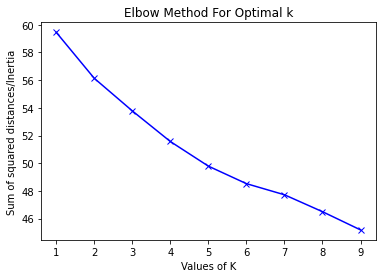

In [43]:
la_grouped_clustering = la_grouped.drop('Zip Code', 1)
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters,random_state=0)
    kmeans.fit(la_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

<h3>Determine the optimal K by Silhoutte method</h3>

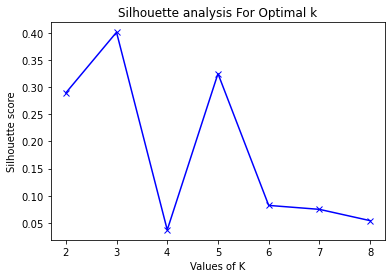

In [48]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(la_grouped_clustering)
    cluster_labels = kmeans.labels_
 # silhouette score
    silhouette_avg.append(silhouette_score(la_grouped_clustering, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

k=5

In [50]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [57]:
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

la_merged = df

la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('Zip Code'), on='ZIP Code')

la_merged.head()

,ZIP Code,Postal City 1,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,90713,Lakewood,33.848711,-118.113579,2.0,Fast Food Restaurant,Smoke Shop,Japanese Restaurant,Video Store,Convenience Store,Discount Store,Coffee Shop,Music Store,Supermarket,Outdoor Gym
1,91306,Winnetka,34.208404,-118.575940,2.0,Fried Chicken Joint,Bar,Grocery Store,Ice Cream Shop,South American Restaurant,Convenience Store,Latin American Restaurant,Mexican Restaurant,Filipino Restaurant,Office
2,90002,Los Angeles,33.948951,-118.246980,1.0,Park,Pharmacy,ATM,Noodle House,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery,Optical Shop
3,90506,Torrance,33.885353,-118.326597,2.0,Fast Food Restaurant,Pizza Place,Mediterranean Restaurant,Mexican Restaurant,Restaurant,Concert Hall,Hookah Bar,Paper / Office Supplies Store,Coffee Shop,Sushi Restaurant
4,90069,West Hollywood,34.089403,-118.379789,2.0,Sushi Restaurant,New American Restaurant,Coffee Shop,Hotel,Salad Place,Gym,Gay Bar,Burger Joint,Café,Sandwich Place


In [59]:
la_merged['Cluster Labels'].unique()
la_merged['Cluster Labels']=la_merged['Cluster Labels'].replace(np.nan,6)

In [61]:
la_merged['Cluster Labels']=la_merged['Cluster Labels'].astype('int')

In [67]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
rainbow = ['blue','green','red','black','yellow','gray','purple']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['ZIP Code'], la_merged['Cluster Labels']):
    if cluster==6:
        label = folium.Popup(str(poi) + ' Cluster ' + 'Outlier', parse_html=True)
    else:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [233]:
cluster0_df=la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]
cluster0_df.head()

,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,91702,Mexican Restaurant,Taco Place,BBQ Joint,ATM,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery
26,91733,Sporting Goods Shop,Furniture / Home Store,Convenience Store,Construction & Landscaping,Food,Mexican Restaurant,ATM,North Indian Restaurant,Outdoor Supply Store,Outdoor Sculpture
30,90602,Indie Theater,Plaza,Convenience Store,Hotel,Mexican Restaurant,North Indian Restaurant,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym
35,90033,Mexican Restaurant,Fast Food Restaurant,Intersection,Pharmacy,Burger Joint,Taco Place,Thai Restaurant,Bank,Bakery,Seafood Restaurant
41,90304,Mexican Restaurant,Taco Place,Convenience Store,Rental Car Location,Park,Seafood Restaurant,Food,Pizza Place,Latin American Restaurant,Organic Grocery


In [234]:
cluster1_df=la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]
cluster1_df.head()

,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,90002,Park,Pharmacy,ATM,Noodle House,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery,Optical Shop
5,91361,Park,Pool,Boat or Ferry,ATM,Noodle House,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors
15,90018,Park,Market,Skate Park,ATM,North Indian Restaurant,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery
51,91208,Park,Cosmetics Shop,Plaza,Middle Eastern Restaurant,North Indian Restaurant,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop
57,90061,Park,Board Shop,Business Service,ATM,Noodle House,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors


In [235]:
cluster2_df=la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]
cluster2_df.head()

,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,90713,Fast Food Restaurant,Smoke Shop,Japanese Restaurant,Video Store,Convenience Store,Discount Store,Coffee Shop,Music Store,Supermarket,Outdoor Gym
1,91306,Fried Chicken Joint,Bar,Grocery Store,Ice Cream Shop,South American Restaurant,Convenience Store,Latin American Restaurant,Mexican Restaurant,Filipino Restaurant,Office
3,90506,Fast Food Restaurant,Pizza Place,Mediterranean Restaurant,Mexican Restaurant,Restaurant,Concert Hall,Hookah Bar,Paper / Office Supplies Store,Coffee Shop,Sushi Restaurant
4,90069,Sushi Restaurant,New American Restaurant,Coffee Shop,Hotel,Salad Place,Gym,Gay Bar,Burger Joint,Café,Sandwich Place
6,90064,Japanese Restaurant,Comic Shop,Pizza Place,Chinese Restaurant,Bar,Salon / Barbershop,Mexican Restaurant,Pet Store,Miscellaneous Shop,Mobile Phone Shop


In [207]:
cluster3_df=la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]
cluster3_df.head()

,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,91724,Construction & Landscaping,ATM,Noodle House,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery
120,91320,Construction & Landscaping,ATM,Noodle House,Outdoors & Recreation,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery
220,91331,Shop & Service,Construction & Landscaping,ATM,Noodle House,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery
357,93591,Construction & Landscaping,Garden Center,ATM,Noodle House,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery


In [237]:
cluster4_df=la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]
cluster4_df

,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
76,91325,Home Service,Flower Shop,Non-Profit,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery,Optical Shop
174,90240,Home Service,ATM,Non-Profit,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery,Optical Shop
276,90265,Home Service,ATM,Non-Profit,Outdoor Supply Store,Outdoor Sculpture,Outdoor Gym,Other Repair Shop,Other Great Outdoors,Organic Grocery,Optical Shop


In [74]:
la_merged.loc[la_merged['Cluster Labels'] == 5, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]

,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


Finding the price of housing by each cluster

In [ ]:
rl='https://www.zillow.com/research/data/https://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1627663404'

In [79]:
house_df=pd.read_csv('Housing.csv')

In [81]:
house_df=house_df[['RegionName','State','City','2021-06-30']]

In [95]:
house_df

,RegionName,State,City,2021-06-30
0,10025,NY,New York,1209625.0
1,60657,IL,Chicago,426430.0
2,10023,NY,New York,1752665.0
3,77494,TX,Katy,302597.0
4,60614,IL,Chicago,480745.0
...,...,...,...,...
27556,4109,ME,Portland,534643.0
27557,21405,MD,Annapolis,839754.0
27558,10118,NY,New York,2725221.0
27559,86343,AZ,Crown King,180944.0


In [238]:
ca_df=house_df.loc[house_df['State'] == 'CA'].sort_values('RegionName')
ca_df['RegionName'].dtype
ca_df

,RegionName,State,City,2021-06-30
2945,90001,CA,Florence-Graham,465037.0
3465,90002,CA,Los Angeles,460436.0
1319,90003,CA,Los Angeles,483458.0
253,90004,CA,Los Angeles,935004.0
1306,90005,CA,Los Angeles,730415.0
...,...,...,...,...
11966,96145,CA,Tahoe City,736177.0
17836,96146,CA,Tahoe City,748273.0
22643,96148,CA,Tahoe Vista,611146.0
5811,96150,CA,South Lake Tahoe,465142.0


In [212]:
price=[]
count=0
for i in cluster0_df['ZIP Code']:
    try:
        ca=ca_df.loc[ca_df['RegionName']==i,'2021-06-30'].values[0]
        price.append(ca)
    except IndexError:
        count+=1
numpy_price0=np.asarray(price)
numpy_price0.mean()

524636.7619047619

In [213]:
price=[]
count=0
for i in cluster1_df['ZIP Code']:
    try:
        ca=ca_df.loc[ca_df['RegionName']==i,'2021-06-30'].values[0]
        price.append(ca)
    except IndexError:
        count+=1
numpy_price1=np.asarray(price)
numpy_price1.mean()

637202.3684210526

In [214]:
price=[]
count=0
for i in cluster2_df['ZIP Code']:
    try:
        ca=ca_df.loc[ca_df['RegionName']==i,'2021-06-30'].values[0]
        price.append(ca)
    except IndexError:
        count+=1
numpy_price2=np.asarray(price)
numpy_price2.mean()

741686.7723577236

In [215]:
price=[]
count=0
for i in cluster3_df['ZIP Code']:
    try:
        ca=ca_df.loc[ca_df['RegionName']==i,'2021-06-30'].values[0]
        price.append(ca)
    except IndexError:
        counr+=1
numpy_price3=np.asarray(price)
numpy_price3.mean()

400524.75

In [216]:
price=[]
count=0
for i in cluster4_df['ZIP Code']:
    try:
        ca=ca_df.loc[ca_df['RegionName']==i,'2021-06-30'].values[0]
        price.append(ca)
    except IndexError:
        count+=1
numpy_price4=np.asarray(price)
numpy_price4.mean()

918945.0

In [228]:
cluster_price=np.array([[0,numpy_price0.mean()],
                          [1,numpy_price1.mean()],
                          [2,numpy_price2.mean()],
                          [3,numpy_price3.mean()],
                          [4,numpy_price4.mean()]])
final_data = pd.DataFrame(cluster_price,columns=['Cluster','Housing Mean Price'])

In [232]:
final_data['Cluster']=final_data['Cluster'].astype('int')
final_data

,Cluster,Housing Mean Price
0,0,524636.761905
1,1,637202.368421
2,2,741686.772358
3,3,400524.750000
4,4,918945.000000
